In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import abel
import scipy.spatial
from timeit import default_timer as timer
from pathlib import Path

In [2]:
def multiply(I,f):
    return np.einsum('rcli,li->rc',I,f)

#Some functions for testing
def flatten_vector(f):
    return f.flatten()
def revert_vector(f,H,W):
    return np.reshape(f,(H,W//2+1))
def flatten_matrix(I,H,W):
    return np.reshape(I,(H*(W//2+1),H*(W//2+1)))
def revert_matrix(I,H,W):
    d = np.int(I.shape[0]**0.5)
    return np.reshape(I,(H,W//2+1,H,W//2+1))
def reduce_matrix(matrix):
    d = matrix.shape[1]
    return (matrix[:,:d//2+1,:,:]+np.flip(matrix[:,d//2:,:,:],axis=1))/2

## Load matrix

In [3]:
path = Path.cwd()/'matrices'

In [4]:
N = 65
I = np.load(path/'mat_{}.npy'.format(N))
I = reduce_matrix(I)
#Delete boundary entries
I = I[:,1:,:,:-1] #remove outermost pixel and isoline radius
N_new = N
H = N_new #top, bottom
W = N
W_new = W-2#right,left
I.shape

(65, 32, 65, 32)

In [5]:
# Analytical inverse Abel: 
n = W//2+1
print(n)
r_max = 1
sigma = 0.5

ref = abel.tools.analytical.GaussianAnalytical(n, r_max, sigma,symmetric=False)

R = np.linspace(0,1,n) #Be careful with n here!
h = np.flip(np.linspace(-1,1,N_new)) #from top to bottom

33


## Gaussian in each row

In [7]:
func = np.exp(-R[:-1]**2/sigma**2)
#func = np.exp(-R**2/sigma**2)
func2 = np.zeros((N_new,n-1))
abel2d = np.zeros((N_new,n))
for i in range(N_new):
    func2[i,:] = func
    abel2d[i,:] = ref.abel

In [44]:
pure_signal = np.flip(multiply(I,func2),axis=1)
noise_ratio = 0.002
noise = pure_signal.std() * noise_ratio * np.random.normal(0,1,pure_signal.shape)
#noise = np.flip(np.sort(noise))

noisy_signal = pure_signal + noise

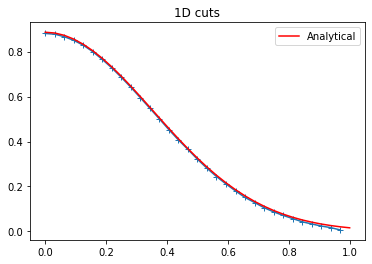

In [46]:
ab = np.flip(multiply(I,func2),axis=1)
for i in range(N):
    if i==30:
        plt.plot(ref.r[:-1],noisy_signal[i,:],marker='+')
        #plt.plot(ref.r,ab[i,:],marker='+')

plt.plot(ref.r,ref.abel,c='red',label='Analytical')
plt.legend()
plt.title('1D cuts')
plt.show()

In [45]:
x,res,ran,sing=np.linalg.lstsq(flatten_matrix(I,H,W-2),flatten_vector(np.flip(noisy_signal,axis=1)))
#x,res,ran,sing=np.linalg.lstsq(flatten_matrix(I,H,W),flatten_vector(np.flip(abel2d,axis=1)))

<ipython-input-45-a92d2464ff63>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x,res,ran,sing=np.linalg.lstsq(flatten_matrix(I,H,W-2),flatten_vector(np.flip(noisy_signal,axis=1)))


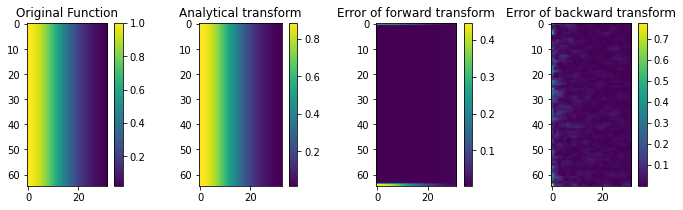

In [47]:
plt.figure(figsize=(12, 3))
plt.subplot(141)
plt.imshow(func2)
plt.colorbar()
plt.title('Original Function')
plt.subplot(142)
plt.imshow(abel2d)
plt.colorbar()
plt.title('Analytical transform')
plt.subplot(143)
plt.imshow(np.abs(np.flip(multiply(I,func2),axis=1)-abel2d[:,:-1]))
#plt.imshow(np.abs(np.flip(multiply(I,func2),axis=1)-abel2d))
plt.colorbar()
plt.title('Error of forward transform')
plt.subplot(144)
plt.imshow(np.abs(revert_vector(x,H,W-2)-func2))
plt.colorbar()
plt.title('Error of backward transform')
plt.show()

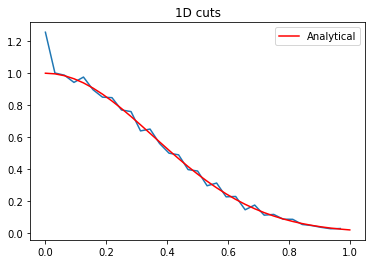

In [48]:
X = revert_vector(x,H,W-2)
for i in range(N):
    if i==20:
        plt.plot(ref.r[:-1],X[i,:])
        #plt.plot(ref.r,X[i,:])
plt.plot(ref.r,ref.func,c='red',label='Analytical')
plt.legend()
plt.title('1D cuts')
plt.show()
#Notice that it gets better towards the middle